<font size="+3"><strong>5.3. Ensemble Models: Random Forest</strong></font>

So far in this project, we've learned how to retrieve and decompress data, and how to manage imbalanced data to build a decision-tree model.

In this lesson, we're going to expand our decision tree model into an entire forest (an example of something called an **ensemble model**); learn how to use a **grid search** to tune hyperparameters; and create a function that loads data and a pre-trained model, and uses that model to generate a Series of predictions.

In [3]:
VimeoVideo("694695674", h="538b4d2725", width=600)

In [2]:
from IPython.display import VimeoVideo

# Prepare Data

As always, we'll begin by importing the dataset.

## Import

**Task 5.3.1:** Complete the `wrangle` function below using the code you developed in the  lesson 5.1. Then use it to import `poland-bankruptcy-data-2009.json.gz` into the DataFrame `df`.

- [<span id='technique'>Write a function in <span id='tool'>Python</span></span>.](../%40textbook/02-python-advanced.ipynb#Functions)

In [3]:
def wrangle(filename):
    
    # Open compressed file, load into dictionary
    with gzip.open(filename,"r") as f:
        data = json.load(f)
    
    # Load dictionary into DataFrame, set index
    df = pd.DataFrame().from_dict(data["data"]).set_index("company_id")
    return df

In [4]:
df = wrangle("data/poland-bankruptcy-data-2009.json.gz")
print(df.shape)
df.head()

(9977, 65)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64,bankrupt
company_id,,,,,,,,,,,,,,,,,,,,,
1,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.12250,1.1961,0.46359,...,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,False
2,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.17210,1.6018,0.53962,...,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,False
3,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.98810,1.0077,0.67566,...,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,False
5,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.40940,1.3393,0.58496,...,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,False
6,0.182060,0.55615,0.32191,1.6045,16.3140,0.00000,0.182060,0.79808,1.8126,0.44385,...,0.555770,0.410190,0.46957,0.029421,8.4553,3.3488,107.240,3.4036,12.4540,False


## Split

**Task 5.3.2:** Create your feature matrix `X` and target vector `y`. Your target is `"bankrupt"`. 

- [What's a <span id='term'>feature matrix</span>?](../%40textbook/15-ml-regression.ipynb#Linear-Regression)
- [What's a <span id='term'>target vector</span>?](../%40textbook/15-ml-regression.ipynb#Linear-Regression)
- [<span id='technique'>Subset a DataFrame by selecting one or more columns in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Subset-a-DataFrame-by-Selecting-One-or-More-Columns) 
- [<span id='technique'>Select a Series from a DataFrame in <span id='tool'>pandas</span></span>.](../%40textbook/04-pandas-advanced.ipynb#Combine-multiple-categories-in-a-Series) 

In [5]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (9977, 64)
y shape: (9977,)


Since we're not working with time series data, we're going to randomly divide our dataset into training and test sets — just like we did in project 4.

**Task 5.3.3:** Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. And don't forget to set a `random_state` for reproducibility. 

- [<span id='technique'>Perform a randomized train-test split using <span id='tool'>scikit-learn</span></span>.](../%40textbook/14-ml-classification.ipynb#Randomized-Train-Test-split)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
X,y,test_size=0.2,random_state=42
)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (7981, 64)
y_train shape: (7981,)
X_test shape: (1996, 64)
y_test shape: (1996,)


You might have noticed that we didn't create a validation set, even though we're planning on tuning our model's hyperparameters in this lesson. That's because we're going to use cross-validation, which we'll talk about more later on.

## Resample

In [12]:
VimeoVideo("694695662", h="dc60d76861", width=600)

**Task 5.3.4:** Create a new feature matrix `X_train_over` and target vector `y_train_over` by performing random over-sampling on the training data.

- [What is over-sampling?](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Over-sampling)
- [Perform random over-sampling using imbalanced-learn.](../%40textbook/13-ml-data-pre-processing-and-production.ipynb#Over-sampling)

In [7]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (15194, 64)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_55,feat_56,feat_57,feat_58,feat_59,feat_60,feat_61,feat_62,feat_63,feat_64
0,0.279320,0.053105,0.852030,17.0440,199.080,0.741770,0.353570,16.00600,1.2346,0.84997,...,52857.00,0.190040,0.328630,0.80996,0.00000,NaN,4.1858,11.002,33.1760,18.5720
1,0.001871,0.735120,0.156460,1.2269,-10.837,0.000000,0.002938,0.36032,1.4809,0.26488,...,440.02,0.014794,0.007064,0.99803,0.00000,7.4268,2.2925,169.960,2.1476,9.6185
2,0.113940,0.490250,0.077121,1.2332,-43.184,-0.000171,0.113940,1.03980,1.1649,0.50975,...,4617.40,0.214890,0.223520,0.78761,0.27412,6.2791,6.1622,103.630,3.5220,1.9673
3,0.008136,0.652610,0.148120,1.2628,29.071,0.000000,0.008136,0.53230,1.2891,0.34739,...,920.98,0.045169,0.023421,0.99434,0.14403,22.7480,2.2673,159.580,2.2872,4.4718
4,0.045396,0.279640,0.708730,3.7656,238.120,0.000000,0.056710,2.57610,1.0169,0.72036,...,10744.00,0.047501,0.063019,0.94624,0.00000,13.8860,49.0660,91.984,3.9681,29.0460


# Build Model

Now that we have our data set up the right way, we can build the model. 🏗

## Baseline

**Task 5.3.5:** Calculate the baseline accuracy score for your model.

- [What's <span id='tool'>accuracy score</span>?](../%40textbook/14-ml-classification.ipynb#Calculating-Accuracy-Score)
- [Aggregate data in a Series using `value_counts` in pandas.](../%40textbook/04-pandas-advanced.ipynb#Working-with-value_counts-in-a-Series)

In [8]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 4))

Baseline Accuracy: 0.9519


## Iterate

So far, we've built single models that predict a single outcome. That's definitely a useful way to predict the future, but what if the one model we built isn't the *right* one? If we could somehow use more than one model simultaneously, we'd have a more trustworthy prediction.

**Ensemble models** work by building multiple models on random subsets of the same data, and then comparing their predictions to make a final prediction. Since we used a decision tree in the last lesson, we're going to create an ensemble of trees here. This type of model is called a **random forest**.

We'll start by creating a pipeline to streamline our workflow.

In [9]:
VimeoVideo("694695643", h="32c3d5b1ed", width=600)

**Task 5.3.6:** Create a pipeline named `clf` (short for "classifier") that contains a `SimpleImputer` transformer and a `RandomForestClassifier` predictor.

- [What's an ensemble model?](../%40textbook/14-ml-classification.ipynb#Classification-with-Ensemble-Models)
- [What's a random forest model?](../%40textbook/14-ml-classification.ipynb#Random-Forest)

In [10]:
clf = make_pipeline(
SimpleImputer(),RandomForestClassifier(random_state=42)
)
print(clf)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])


By default, the number of trees in our forest (`n_estimators`) is set to 100. That means when we train this classifier, we'll be fitting 100 trees. While it will take longer to train, it will hopefully lead to better performance.

In order to get the best performance from our model, we need to tune its hyperparameter. But how can we do this if we haven't created a validation set? The answer is **cross-validation**. So, before we look at hyperparameters, let's see how cross-validation works with the classifier we just built.

In [11]:
VimeoVideo("694695619", h="2c41dca371", width=600)

**Task 5.3.7:** Perform cross-validation with your classifier, using the over-sampled training data. We want five folds, so set `cv` to 5. We also want to speed up training, to set `n_jobs` to -1.

- [What's cross-validation?](../%40textbook/14-ml-classification.ipynb#Cross-Validation)
- [Perform k-fold cross-validation on a model in scikit-learn.](../%40textbook/14-ml-classification.ipynb#Cross-Validation)

In [13]:
cv_acc_scores = cross_val_score(clf,X_train_over,y_train_over,cv=5,n_jobs=-1,verbose=True)
print(cv_acc_scores)

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[0.99670944 0.99835472 0.99769661 0.9970385  0.99901251]


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   53.3s finished


That took kind of a long time, but we just trained 500 random forest classifiers (100 jobs x 5 folds). No wonder it takes so long!

Pro tip: even though `cross_val_score` is useful for getting an idea of how cross-validation works, you'll rarely use it. Instead, most people include a `cv` argument when they do a hyperparameter search. 

Now that we have an idea of how cross-validation works, let's tune our model. The first step is creating a range of hyperparameters that we want to evaluate. 

In [14]:
VimeoVideo("694695593", h="5143f0b63f", width=600)

**Task 5.3.8:** Create a dictionary with the range of hyperparameters that we want to evaluate for our classifier. 

1. For the `SimpleImputer`, try both the `"mean"` and `"median"` strategies. 
2. For the `RandomForestClassifier`, try `max_depth` settings between 10 and 50, by steps of 10. 
3. Also for the `RandomForestClassifier`, try `n_estimators` settings between 25 and 100 by steps of 25.

- [What's a dictionary?](../%40textbook/01-python-getting-started.ipynb#Python-Dictionaries)
- [What's a hyperparameter?](../%40textbook/17-ts-core.ipynb#Hyperparameters)
- [Create a range in Python](../%40textbook/18-ts-models.ipynb#Hyperparameters)
- [Define a hyperparameter grid for model tuning in scikit-learn.](../%40textbook/14-ml-classification.ipynb#Hyperparameter-Tuning)

In [18]:
params = {
"simpleimputer__strategy":["mean","median"],
"randomforestclassifier__n_estimators":range(25,100,25),
"randomforestclassifier__max_depth":range(10,50,10)
}
params

{'simpleimputer__strategy': ['mean', 'median'],
 'randomforestclassifier__n_estimators': range(25, 100, 25),
 'randomforestclassifier__max_depth': range(10, 50, 10)}

Now that we have our hyperparameter grid, let's incorporate it into a **grid search**.

In [15]:
VimeoVideo("694695574", h="8588bf015f", width=600)

**Task 5.3.9:** Create a `GridSearchCV` named `model` that includes your classifier and hyperparameter grid. Be sure to use the same arguments for `cv` and `n_jobs` that you used above, and set `verbose` to 1. 

- [What's cross-validation?](../%40textbook/14-ml-classification.ipynb#Cross-Validation)
- [What's a grid search?](../%40textbook/14-ml-classification.ipynb#Grid-Search)
- [Perform a hyperparameter grid search in scikit-learn.](../%40textbook/14-ml-classification.ipynb#Grid-Search)

In [20]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
    
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

Finally, now let's fit the model.

In [16]:
VimeoVideo("694695566", h="f4e9910a9e", width=600)

**Task 5.3.10:** Fit `model` to the over-sampled training data.

In [21]:
# Train model
model.fit(X_train_over,y_train_over)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 50, 10),
                         'randomforestclassifier__n_estimators': range(25, 100, 25),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

This will take some time to train, so let's take a moment to think about why. How many forests did we just test? 4 different `max_depth`s times 3 `n_estimator`s times 2 imputation strategies... that makes 24 forests. How many fits did we just do? 24 forests times 5 folds is 120. And remember that each forest is comprised of 25-75 trees, which works out to *at least* 3,000 trees. So it's computationally expensive! 

Okay, now that we've tested all those models, let's take a look at the results.

In [17]:
VimeoVideo("694695546", h="4ae60129c4", width=600)

**Task 5.3.11:** Extract the cross-validation results from `model` and load them into a DataFrame named `cv_results`.

- [Get cross-validation results from a hyperparameter search in scikit-learn.](../%40textbook/14-ml-classification.ipynb#Grid-Search)

In [23]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,param_simpleimputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.319841,0.052371,0.028777,0.024166,10,25,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.979269,0.977295,0.977953,0.980915,0.982225,0.979532,0.001829,21
1,2.522114,0.026328,0.053664,0.030180,10,25,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.978611,0.969069,0.975650,0.970056,0.974984,0.973674,0.003586,24
2,4.639293,0.092312,0.077404,0.024477,10,50,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.983218,0.979599,0.978282,0.984534,0.983871,0.981901,0.002488,20
3,4.805260,0.062820,0.040943,0.024404,10,50,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.980257,0.971043,0.978940,0.978282,0.977617,0.977228,0.003213,23
4,6.910971,0.060821,0.101708,0.000863,10,75,mean,"{'randomforestclassifier__max_depth': 10, 'ran...",0.984205,0.980586,0.976966,0.984534,0.984529,0.982164,0.002996,19
5,7.102437,0.114088,0.103155,0.001336,10,75,median,"{'randomforestclassifier__max_depth': 10, 'ran...",0.980915,0.972688,0.981573,0.979928,0.981567,0.979334,0.003377,22
6,2.678430,0.031069,0.056105,0.030202,20,25,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996380,0.997038,0.995722,0.995393,0.997367,0.996380,0.000750,17
7,2.879248,0.031367,0.044928,0.031034,20,25,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.995722,0.996709,0.997368,0.996380,0.998025,0.996841,0.000795,14
8,5.299092,0.009935,0.094759,0.000412,20,50,mean,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996709,0.996709,0.995722,0.995064,0.997367,0.996314,0.000816,18
9,5.483608,0.037390,0.095562,0.000752,20,50,median,"{'randomforestclassifier__max_depth': 20, 'ran...",0.996051,0.997368,0.998026,0.996709,0.998354,0.997302,0.000843,11


In addition to the accuracy scores for all the different models we tried during our grid search, we can see how long it took each model to train. Let's take a closer look at how different hyperparameter settings affect training time. 

First, we'll look at `n_estimators`. Our grid search evaluated this hyperparameter for various `max_depth` settings, but let's only look at models where `max_depth` equals 10.

In [24]:
VimeoVideo("694695537", h="e460435664", width=600)

**Task 5.3.12:** Create a mask for `cv_results` for rows where `"param_randomforestclassifier__max_depth"` equals 10. Then plot `"param_randomforestclassifier__n_estimators"` on the x-axis and `"mean_fit_time"` on the y-axis. Don't forget to label your axes and include a title. 

- [Subset a DataFrame with a mask using pandas.](../%40textbook/04-pandas-advanced.ipynb)
- [Create a line plot in Matplotlib.](../%40textbook/06-visualization-matplotlib.ipynb)

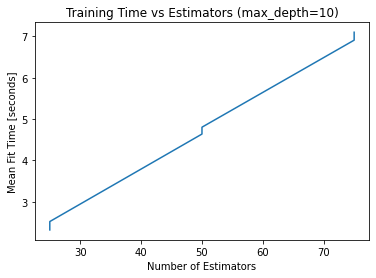

In [28]:
# Create mask
mask = cv_results["param_randomforestclassifier__max_depth"]==10

# Plot fit time vs n_estimators
plt.plot(
    cv_results[mask]["param_randomforestclassifier__n_estimators"],
    cv_results[mask]["mean_fit_time"]
)

# Label axes
plt.xlabel("Number of Estimators")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Estimators (max_depth=10)");

Next, we'll look at `max_depth`. Here, we'll also limit our data to rows where `n_estimators` equals 25.

In [29]:
VimeoVideo("694695525", h="99f2dfc9eb", width=600)

**Task 5.3.13:** Create a mask for `cv_results` for rows where `"param_randomforestclassifier__n_estimators"` equals 25. Then plot `"param_randomforestclassifier__max_depth"` on the x-axis and `"mean_fit_time"` on the y-axis. Don't forget to label your axes and include a title. 

- [Subset a DataFrame with a mask using pandas.](../%40textbook/04-pandas-advanced.ipynb)
- [Create a line plot in Matplotlib.](../%40textbook/06-visualization-matplotlib.ipynb)

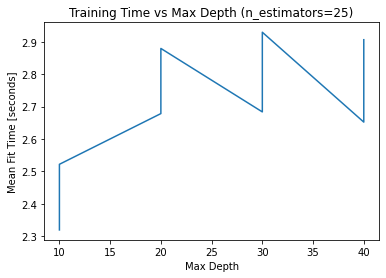

In [30]:
# Create mask
mask = cv_results["param_randomforestclassifier__n_estimators"]==25
# Plot fit time vs max_depth
plt.plot(
    cv_results[mask]["param_randomforestclassifier__max_depth"],
    cv_results[mask]["mean_fit_time"]
)
# Label axes
plt.xlabel("Max Depth")
plt.ylabel("Mean Fit Time [seconds]")
plt.title("Training Time vs Max Depth (n_estimators=25)");

There's a general upwards trend, but we see a lot of up-and-down here. That's because for each max depth, grid search tries two different imputation strategies: mean and median. Median is a lot faster to calculate, so that speeds up training time. 

Finally, let's look at the hyperparameters that led to the best performance. 

In [31]:
VimeoVideo("694695505", h="f98f660ce1", width=600)

**Task 5.3.14:** Extract the best hyperparameters from `model`.

- [Get settings from a hyperparameter search in scikit-learn.](../%40textbook/14-ml-classification.ipynb#Cross-Validation)

In [33]:
# Extract best hyperparameters
model.best_score_

0.9978939791055105

Note that we don't need to build and train a new model with these settings. Now that the grid search is complete, when we use `model.predict()`, it will serve up predictions using the best model — something that we'll do at the end of this lesson.

## Evaluate

All right: The moment of truth. Let's see how our model performs.

**Task 5.3.15:** Calculate the training and test accuracy scores for `model`. 

- [<span id='technique'>Calculate the accuracy score for a model in <span id='term'>scikit-learn</span></span>.](../%40textbook/14-ml-classification.ipynb#Calculating-Accuracy-Score)

In [34]:
acc_train = model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 1.0
Test Accuracy: 0.9589


We beat the baseline! Just barely, but we beat it. 

Next, we're going to use a confusion matrix to see how our model performs. To better understand the values we'll see in the matrix, let's first count how many observations in our test set belong to the positive and negative classes. 

In [35]:
y_test.value_counts()

False    1913
True       83
Name: bankrupt, dtype: int64

In [36]:
VimeoVideo("694695486", h="1d6ac2bf77", width=600)

**Task 5.3.16:** Plot a confusion matrix that shows how your best model performs on your test set. 

- [What's a confusion matrix?](../%40textbook/14-ml-classification.ipynb#Confusion-Matrix)
- [Create a confusion matrix using scikit-learn.](../%40textbook/14-ml-classification.ipynb#Confusion-Matrix) 

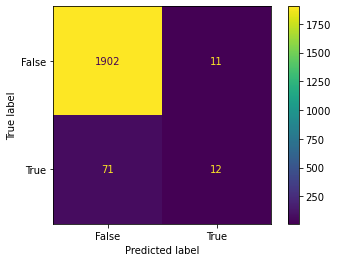

In [38]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test);

Notice the relationship between the numbers in this matrix with the count you did the previous task. If you sum the values in the bottom row, you get the total number of positive observations in `y_test` ($72 + 11 = 83$). And the top row sum to the number of negative observations ($1903 + 10 = 1913$).

# Communicate

In [39]:
VimeoVideo("698358615", h="3fd4b2186a", width=600)

**Task 5.3.17:** Create a horizontal bar chart with the 10 most important features for your model. 

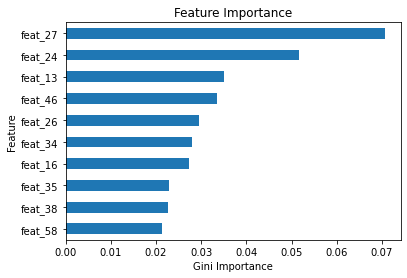

In [41]:
# Get feature names from training data
features = X_train_over.columns
# Extract importances from model
importances = model.best_estimator_.named_steps["randomforestclassifier"].feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances,index=features).sort_values()
# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

The only thing left now is to save your model so that it can be reused.

In [42]:
VimeoVideo("694695478", h="a13bdacb55", width=600)

**Task 5.3.18:** Using a context manager, save your best-performing model to a a file named `"model-5-3.pkl"`. 

- [What's serialization?](../%40textbook/03-pandas-getting-started.ipynb#Pickle-Files)
- [Store a Python object as a serialized file using pickle.](../%40textbook/03-pandas-getting-started.ipynb#Pickle-Files) 

In [44]:
# Save model
with open("model-5-3.pkl","wb") as f:
    pickle.dump(model,f)


In [45]:
VimeoVideo("694695451", h="fc96dd8d1f", width=600)

**Task 5.3.19:** Create a function `make_predictions`. It should take two arguments: the path of a JSON file that contains test data and the path of a serialized model. The function should load and clean the data using the `wrangle` function you created, load the model, generate an array of predictions, and convert that array into a Series. (The Series should have the name `"bankrupt"` and the same index labels as the test data.) Finally, the function should return its predictions as a Series. 

- [What's a function?](../%40textbook/02-python-advanced.ipynb#Functions)
- [Load a serialized file](../%40textbook/03-pandas-getting-started.ipynb#Pickle-Files)
- [What's a Series?](../%40textbook/05-pandas-summary-statistics.ipynb#Series)
- [Create a Series in pandas](../%40textbook/03-pandas-getting-started.ipynb#Working-with-Columns)

In [46]:
def make_predictions(data_filepath, model_filepath):
    # Wrangle JSON file
    X_test = wrangle(data_filepath)
    # Load model
    with open(model_filepath,"rb") as f:
        model = pickle.load(f)
    # Generate predictions
    y_test_pred = model.predict(X_test)
    # Put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred = pd.Series(y_test_pred,index=X_test.index,name="bankrupt")
    return y_test_pred

In [47]:
VimeoVideo("694695426", h="f75588d43a", width=600)

**Task 5.3.20:** Use the code below to check your `make_predictions` function. Once you're satisfied with the result, submit it to the grader. 

In [48]:
y_test_pred = make_predictions(
    data_filepath="data/poland-bankruptcy-data-2009-mvp-features.json.gz",
    model_filepath="model-5-3.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (526,)


company_id
4     False
32    False
34    False
36    False
40    False
Name: bankrupt, dtype: bool

In [49]:
wqet_grader.grade(
    "Project 5 Assessment",
    "Task 5.3.19",
    make_predictions(
        data_filepath="data/poland-bankruptcy-data-2009-mvp-features.json.gz",
        model_filepath="model-5-3.pkl",
    ),
)

---
Copyright © 2022 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
